# Multioutput Gaussian Process test 1, applied to Mocap data-set

Some previous definitions and library invocations needed to process data

In [2]:
%pylab inline
import numpy as np
import pylab as pb
import GPy
import urllib


Populating the interactive namespace from numpy and matplotlib


Fisrt is necesary to retrieve the data from the mocap database located at: http://mocap.cs.cmu.edu/, there one can encounter different datasets of human motion on different situations. There are several files describing the motion of an skeleton, for the purpose of this implementation one can use the .amc files, which specifies the angle of each joint defined by the skeleton for an specific time stamp or frame. The following code retrieves the data of an specific movement previously defined by the user, for that objective first one have to identify the desired motion in this case, a soccer player kicking a ball: http://mocap.cs.cmu.edu/search.php?subjectnumber=10&trinum=6

Then is necesary to copy the link of the amc file located in that page, for this case: mocap.cs.cmu.edu/subjects/10/10_06.amc, then it's only replacing it in the value of the url variable like this:

The file will be downloaded in the same dir where your code or notebook is located, the next code parses the file and extract all the information related with the angles of the joints on each frame, and stores that information in the variable X.

In [3]:
def RetrieveDataFrom(sub, test):
    url = "http://mocap.cs.cmu.edu/subjects/"
    file_name = sub + '_' + test + '.amc'
    url = url + sub + '/' + file_name
    url = (url) # Tell to python where is the file
    urllib.urlretrieve(url, file_name) # Tell python to retrieve the file
    amc_file = open(file_name, 'r')
    print 'File ' + file_name + ' succesfully downloaded'
    cont = 0
    read_frames = False
    print 'Reading header...' 
    frame = 1
    bone = 0
    bone_map_dof = {} # Saves the degree of freedom of each joint the key is the signal id
    bone_name = {} # saves the id and the name of the joint
    all_samples = {} 
    bone_map_id = [] # A list of tuples (a,b), a: id of the joint, b: id of the signal corresponding to each joint Dof

    samples_frame = 0
    for mline in amc_file:
        if(mline == ":DEGREES\r\n" and read_frames == False):
            read_frames = True
            print 'now reading frames'
            continue
        elif(read_frames):
            params = mline.split(' ')
            if params[0] == str(frame) + '\r\n':
                #print 'reading frame: ' + str(frame)
                if(frame >= 2):
                    #print samples_frame
                    all_samples[frame - 1] = samples_frame

                samples_frame = 0
                frame += 1
                bone = 1
            else:
                if(bone == 1):
                    samples_frame = np.array(params[1:len(params)], dtype=float)
                    #print samples_frame
                    bone_map_dof[bone] = len(params) - 1
                    bone_name[bone] = params[0]
                    if(frame == 2):
                        for i in range(0,len(params) - 1):
                            tmp_tuple = (bone, i+1)
                            bone_map_id.append(tmp_tuple)
                else:        		
                    bone_sample = np.array(params[1:len(params)], dtype=float)
                    samples_frame = np.append(samples_frame, bone_sample)
                    bone_map_dof[bone] = len(params) - 1
                    bone_name[bone] = params[0]
                    if(frame == 2):
                        for i in range(0,len(params) - 1):
                            tmp_tuple = (bone, i+1)
                            bone_map_id.append(tmp_tuple)
                bone += 1

    all_samples[frame - 1] = samples_frame
    #print all_samples[1], bone_map, bone_name
    X = np.zeros((all_samples[1].shape[0], len(all_samples)))

    for i in range(0,len(all_samples)):
        X[:,i] = all_samples[i + 1]
    print 'File succesfully loaded'
    return X

def GetMotionFiles(subjec_test_list):
    for i in subjec_test_list:
        sub = i[0]
        test = i[1]
        RetrieveDataFrom(sub, test)
    print 'Subject tests files retrieved succesfully'
    return 0        

def GetJoints(djoints, X):
    X_joints = np.zeros((1,X.shape[1]))
    signals_id = []
    #X_joints = np.matrix(X_joints)
    for i in djoints:
        l = 0
        k = 0
        tmp_samples = 0
        for j in bone_map_dof:
            k += bone_map_dof[j]
            if(i == j):
                tmp_samples = X[l:k,:]
                X_joints = np.vstack((X_joints, tmp_samples))
                for w in range(0,bone_map_dof[j]):
                    tmp_tuple = (i, w + 1)
                    signals_id.append(tmp_tuple)
                break       
            l = k
    #print X_joints.shape
    X_joints = X_joints[1:X_joints.shape[0], :]
    #print X_joints.shape
    #print signals_id
    return X_joints, signals_id

def SubSampling(data, samples):    
    ret = np.zeros((data.shape[0], samples))
    #ret = np.matrix(ret)
    if(samples > data.shape[1]/2):
        print 'samples need to be less or equal than half of the real size'
        return ret 
    
    dif = data.shape[1]/samples
    cont = 0
    idx = 0
    while idx < samples:
        #print cont,idx
        ret[:, idx] = data[:, cont]
        cont += dif
        idx += 1
    return ret       


def IsNoisySignal(X,Y):
    d = 1          # input dimension
    var = 10.       # variance
    theta = 50.0 
    k = GPy.kern.RBF(d, variance=var, lengthscale=theta)
    C = k.K(X)
    m = GPy.models.GPRegression(X,Y,k)
    m.optimize()
    var_signal = m.rbf.variance
    #print m
    var_noise = m.Gaussian_noise.variance
    return (np.log(var_signal / var_noise) <= 0.0) # signal to noise ratio

def RemoveNoisySignals(X, input_t, bone_map_id):
    ret_X = X
    ret_bone_map_id = []
    noise_index = np.ones(ret_X.shape[0], dtype=bool)
    for i in range(0, X.shape[0]):
        Y = X[i,:]
        #pb.plot(input_t, X[i,:])
        Y = Y[:,None]
        if IsNoisySignal(input_t, Y):
            print 'removing noisy signal: ', 'bone: ', bone_name[bone_map_id[i][0]], ' DoF number: ', bone_map_id[i][1]
            noise_index[i] = False
            
    ret_X = ret_X[noise_index, :]
    for i in range(X.shape[0]):
        if(noise_index[i]):
            ret_bone_map_id.append(bone_map_id[i])

    return ret_X, ret_bone_map_id
    

desired_subject_tests = [('35','10'), ('17', '04'), ('17', '07')]
GetMotionFiles(desired_subject_tests)

'''
desired_joints = [8,9,10,12,15,16,17,19]
XX = X
X, bone_map_id = GetJoints(desired_joints, X)
X_sub_sampled = SubSampling(X, 200)
X = X_sub_sampled
time_stamps = np.arange(X.shape[1])
input_t = time_stamps
input_t = input_t[:,None]

for i in desired_joints:
    print i, bone_name[i]

print X.shape, len(bone_map_id)
X,bone_map_id = RemoveNoisySignals(X, input_t, bone_map_id)
print X.shape, len(bone_map_id)
print bone_map_id'''

File 35_10.amc succesfully downloaded
Reading header...
now reading frames
File succesfully loaded
File 17_04.amc succesfully downloaded
Reading header...
now reading frames
File succesfully loaded
File 17_07.amc succesfully downloaded
Reading header...
now reading frames
File succesfully loaded
Subject tests files retrieved succesfully


'\ndesired_joints = [8,9,10,12,15,16,17,19]\nXX = X\nX, bone_map_id = GetJoints(desired_joints, X)\nX_sub_sampled = SubSampling(X, 200)\nX = X_sub_sampled\ntime_stamps = np.arange(X.shape[1])\ninput_t = time_stamps\ninput_t = input_t[:,None]\n\nfor i in desired_joints:\n    print i, bone_name[i]\n\nprint X.shape, len(bone_map_id)\nX,bone_map_id = RemoveNoisySignals(X, input_t, bone_map_id)\nprint X.shape, len(bone_map_id)\nprint bone_map_id'

# Multioutput Gaussian Processes

In this section we will try to make multioutput regression using all the outputs of the mocap database , first the covariance matrix will be calculated, then it will be used to make some samples of each for some of the outputs loaded before, some of the points in some of the outputs will be ommited and it will be evaluated the accuracy of the prediction made by the process on those outputs which some of its data points were omitted.

16


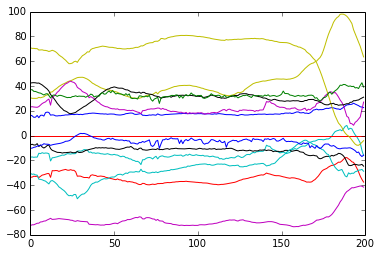

In [6]:
print X.shape[0]
for i in range(0,X.shape[0]):
    # extract the event 
    x_event = time_stamps
    y_event = X[i,:]
    pb.plot(x_event, y_event)
    

The graph above represents all the outputs of the motion of the body for a ceratin sequence. Next it's neccesary to accomodate the input variable(time) as one column vector and the id's of the outputs also in the same way to use the covariance function and the coregionalization matrix respectively.

In [7]:
def SetInputTMOGP(X, input_t, n_signals=5):
    sup_input = input_t[:,0]
    sup_input_id = np.zeros(input_t.shape[0])
    sup_output = X[0,:]
    tmp_output = sup_output
    tmp_input = sup_input
    
    for i in range(1,n_signals):
        tmp_input = np.append(tmp_input, sup_input)
        tmp_input_id = np.linspace(i,i,X.shape[1])
        sup_input_id = np.append(sup_input_id, tmp_input_id)
        tmp_output = np.append(tmp_output, X[i,:])

    sup_input = tmp_input
    #sup_input = sup_input*(1/100.0)
    sup_output = tmp_output
    sup_output = sup_output[:,None]
    all_X = np.vstack((sup_input, sup_input_id))
    all_X = np.transpose(all_X)
    return all_X, sup_output

def ComputeMSQERR(a,b):
    mean_sq_err = a - b
    mean_sq_err = np.power(mean_sq_err, 2)
    val_mean_sq_err = np.sum(mean_sq_err) / mean_sq_err.shape[0]
    return val_mean_sq_err

def ComputeSMSE(F, Y, var):
    mean_sq_err = Y - F
    mean_sq_err = np.power(mean_sq_err, 2)
    all_var = np.sum(var)
    sms_err = mean_sq_err/all_var
    val_smse = np.sum(sms_err)/F.shape[0]
    return val_smse

def ComputeSLL(F, Y, var, gaussian_noise_var):
    #print gaussian_noise_var.shape
    mean_sq_err = Y - F
    var = var + gaussian_noise_var
    mean_sq_err = np.power(mean_sq_err, 2)
    mean_sq_err = np.divide(mean_sq_err, 2.0*var)
    log_term = 0.5*np.log(var*2.0*np.pi)
    sll = log_term + mean_sq_err
    val_sll = np.sum(sll)/F.shape[0]
    return -1.0*val_sll

def PlottingModel(t,X,model,n_outputs):
    for i in range(n_outputs):
        model.plot(fignum=1,fixed_inputs=[(1, i)], plot_raw=True)

    for i in range(0,n_outputs):
        # extract the event 
        x_event = t
        y_event = X[i,:]
        pb.plot(x_event, y_event)
